In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

i_1=pd.read_csv('~/git/BD/temp/imp_fert_mun1.csv').sort_values(by=['CO_ANO','CO_MES']).rename(columns={'SH4':'CO_SH4'})

uf=pd.read_csv('~/git/BD/Comexstat/tab_complementares/UF.csv',encoding='Latin-1',sep=';')
pais=pd.read_csv('~/git/BD/Comexstat/tab_complementares/PAIS.csv',encoding='Latin-1',sep=';')
mun=pd.read_csv('~/git/BD/Comexstat/tab_complementares/UF_MUN.csv',encoding='Latin-1',sep=';').rename(columns={'CO_MUN_GEO':'CO_MUN'})
sh=pd.read_csv('~/git/BD/Comexstat/tab_complementares/NCM_SH.csv',encoding='Latin-1',sep=';')
ncm=pd.read_csv('~/git/BD/Comexstat/tab_complementares/NCM.csv',encoding='Latin-1',sep=';')

i_1=i_1[i_1.SG_UF_MUN=='BA'].drop(columns='SG_UF_MUN')
i_1=i_1[i_1.CO_ANO>=2018]
i_1['date']=pd.to_datetime(i_1.CO_ANO.astype(str)+'/'+i_1.CO_MES.astype(str)+'/1')
date_min=i_1.date.min()
date_max=i_1.date.max()
date_range=pd.date_range(start=date_min,end=date_max)

In [2]:
i_1[['CO_ANO','CO_MES','CO_SH4','CO_PAIS','CO_MUN']]=i_1[['CO_ANO','CO_MES','CO_SH4','CO_PAIS','CO_MUN']].astype('category')

i_1=i_1.groupby(by=['CO_ANO','CO_MES','CO_SH4','CO_PAIS','CO_MUN'],observed=False)[['KG_LIQUIDO','VL_FOB']].sum().reset_index()
i_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288120 entries, 0 to 288119
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   CO_ANO      288120 non-null  category
 1   CO_MES      288120 non-null  category
 2   CO_SH4      288120 non-null  category
 3   CO_PAIS     288120 non-null  category
 4   CO_MUN      288120 non-null  category
 5   KG_LIQUIDO  288120 non-null  int64   
 6   VL_FOB      288120 non-null  int64   
dtypes: category(5), int64(2)
memory usage: 5.8 MB


In [3]:
i_1[['CO_ANO','CO_MES','CO_SH4','CO_PAIS','CO_MUN']]=i_1[['CO_ANO','CO_MES','CO_SH4','CO_PAIS','CO_MUN']].astype(str)

In [4]:
i_1['date']=pd.to_datetime(i_1.CO_ANO.astype(str)+'/'+i_1.CO_MES.astype(str)+'/1')
i_1=i_1[(i_1.date>=date_min)&(i_1.date<=date_max)]
i_1=i_1.merge(mun[['NO_MUN','CO_MUN']].astype(str)).merge(pais[['NO_PAIS','CO_PAIS']].astype(str)).merge(sh[['NO_SH4_POR','CO_SH4']].astype(str))
i_1.head(1)

,CO_ANO,CO_MES,CO_SH4,CO_PAIS,CO_MUN,KG_LIQUIDO,VL_FOB,date,NO_MUN,NO_PAIS,NO_SH4_POR
0,2018,1,3101,23,2905701,0,0,2018-01-01,CAMACARI,Alemanha,Adubos (fertilizantes) de origem animal ou veg...


In [24]:
i_1[i_1.CO_ANO.astype(int)==2023].KG_LIQUIDO.sum()/10**9

np.float64(13.314923539)

# MUNICÍPIO

In [5]:
i_mes_mun=i_1.groupby(by=['date','NO_MUN'])[['KG_LIQUIDO','VL_FOB']].sum().reset_index()
top_mun=i_mes_mun[i_mes_mun.date.dt.year>2020].groupby('NO_MUN').KG_LIQUIDO.sum().reset_index().sort_values(by=['KG_LIQUIDO']).NO_MUN.tail(3).tolist()
top_mun

['CONCEICAO DO JACUIPE', 'LUIS EDUARDO MAGALHAES', 'CANDEIAS']

In [6]:
i_mes_mun['mun_top']='Outros'
i_mes_mun.loc[i_mes_mun.NO_MUN.isin(top_mun),'mun_top']=i_mes_mun[i_mes_mun.isin(top_mun)].NO_MUN
i_mes_mun=i_mes_mun.groupby(by=['date','mun_top'])[['KG_LIQUIDO','VL_FOB']].sum().reset_index()
q=pd.DataFrame()
for mun in i_mes_mun.mun_top.unique():
    it=i_mes_mun[i_mes_mun.mun_top==mun].sort_values('date')
    it['kg_12']=it.rolling(12).KG_LIQUIDO.sum()
    it['fob_12']=it.rolling(12).VL_FOB.sum()
    it['dif_kg']=it.kg_12-it.shift(1).kg_12
    it['dif_fob']=it.fob_12-it.shift(1).fob_12
    q=pd.concat([q,it]).dropna()

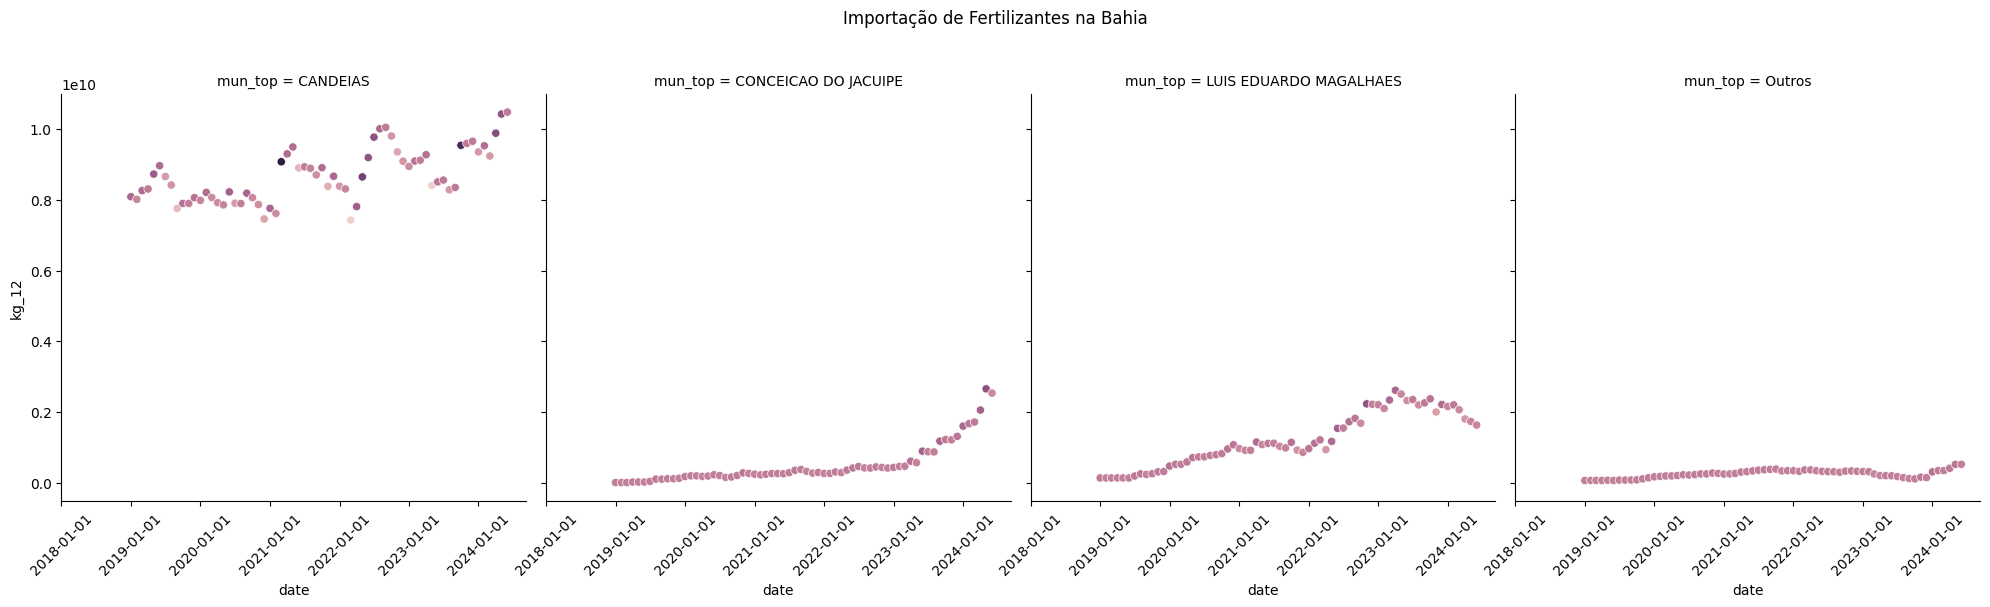

In [7]:
sns.relplot(data=q,x='date',y='kg_12',hue='dif_kg',legend=False,  col='mun_top').set_xticklabels(rotation=45).fig.suptitle('Importação de Fertilizantes na Bahia',y=1.1)
plt.show()

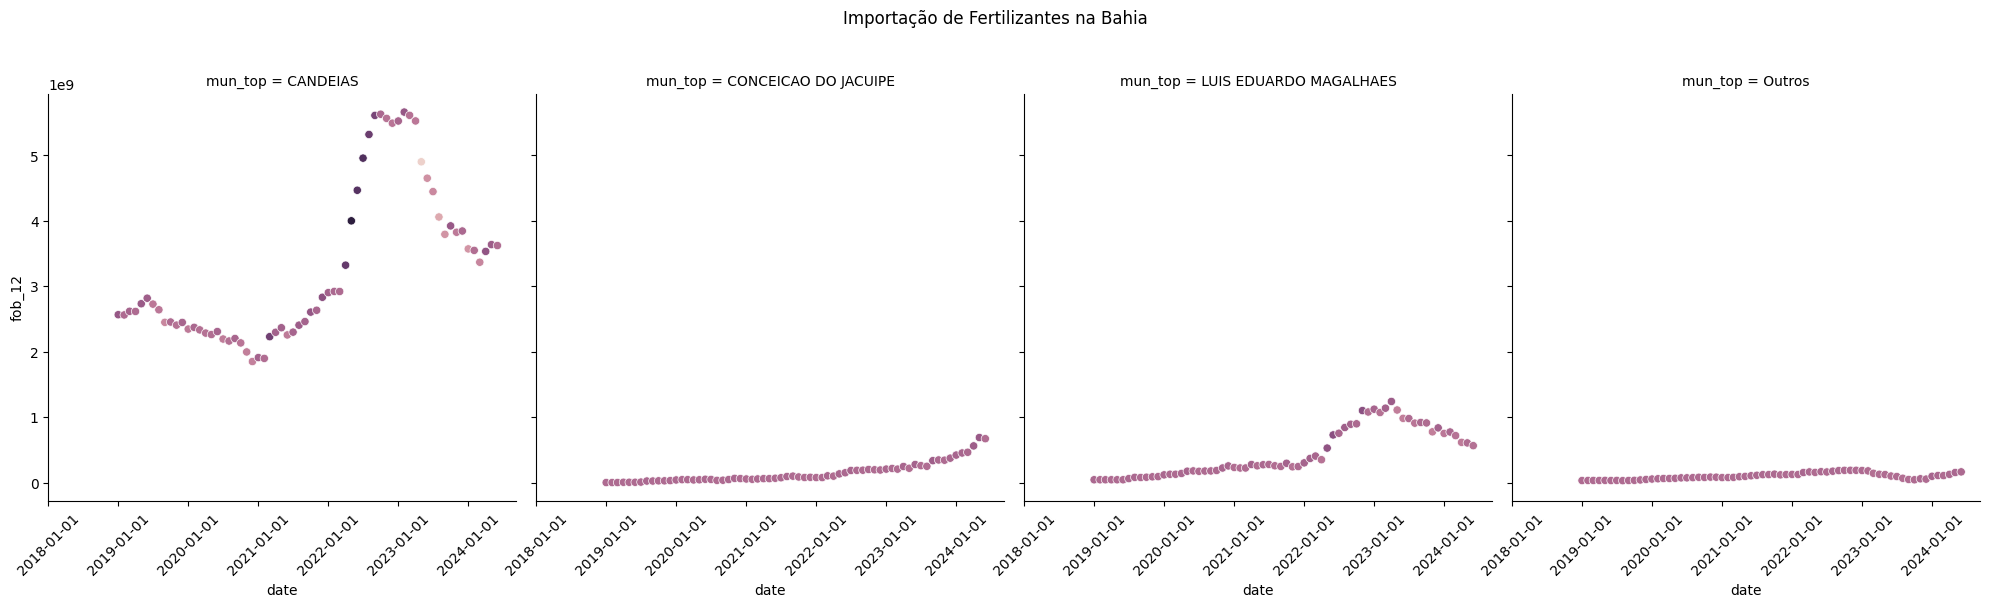

In [8]:
sns.relplot(data=q,x='date',y='fob_12',hue='dif_fob',legend=False,  col='mun_top').set_xticklabels(rotation=45).fig.suptitle('Importação de Fertilizantes na Bahia',y=1.1)
plt.show()

# SH4

In [9]:
i_mes_sh4=i_1.groupby(by=['date','NO_SH4_POR'])[['KG_LIQUIDO','VL_FOB']].sum().reset_index()
top_sh4=i_mes_sh4[i_mes_sh4.date.dt.year>2020].groupby('NO_SH4_POR').KG_LIQUIDO.sum().reset_index().sort_values(by=['KG_LIQUIDO']).NO_SH4_POR.tail(3).tolist()
top_sh4

['Adubos (fertilizantes) minerais ou químicos, potássicos',
 'Adubos (fertilizantes) minerais ou químicos, contendo dois ou três dos seguintes elementos fertilizantes: azoto (nitrogénio), fósforo e potássio; outros adubos (fertilizantes); produtos do presente capítulo apresentados em tabletes ou formas semelhantes, ',
 'Adubos (fertilizantes) minerais ou químicos, azotados']

In [10]:
i_mes_sh4['sh4_top']='Outros'
i_mes_sh4.loc[i_mes_sh4.NO_SH4_POR.isin(top_sh4),'sh4_top']=i_mes_sh4[i_mes_sh4.isin(top_sh4)].NO_SH4_POR
i_mes_sh4=i_mes_sh4.groupby(by=['date','sh4_top'])[['KG_LIQUIDO','VL_FOB']].sum().reset_index()
q=pd.DataFrame()
for sh4 in i_mes_sh4.sh4_top.unique():
    it=i_mes_sh4[i_mes_sh4.sh4_top==sh4].sort_values('date')
    it['kg_12']=it.rolling(12).KG_LIQUIDO.sum()
    it['fob_12']=it.rolling(12).VL_FOB.sum()
    it['dif_kg']=it.kg_12-it.shift(1).kg_12
    it['dif_fob']=it.fob_12-it.shift(1).fob_12
    q=pd.concat([q,it]).dropna()

In [11]:
q.sh4_top=q.sh4_top.str.replace('Adubos (fertilizantes) minerais ou químicos, ', '')

In [12]:
q.sh4_top.unique()

array(['azotados',
       'contendo dois ou três dos seguintes elementos fertilizantes: azoto (nitrogénio), fósforo e potássio; outros adubos (fertilizantes); produtos do presente capítulo apresentados em tabletes ou formas semelhantes, ',
       'potássicos', 'Outros'], dtype=object)

In [13]:
q.sh4_top=q.sh4_top.str.replace('contendo dois ou três dos seguintes elementos fertilizantes: azoto (nitrogénio), fósforo e potássio; outros adubos (fertilizantes); produtos do presente capítulo apresentados em tabletes ou formas semelhantes, ', 'NP_NK_PK_NPK')

In [14]:
q.sh4_top.unique()

array(['azotados', 'NP_NK_PK_NPK', 'potássicos', 'Outros'], dtype=object)

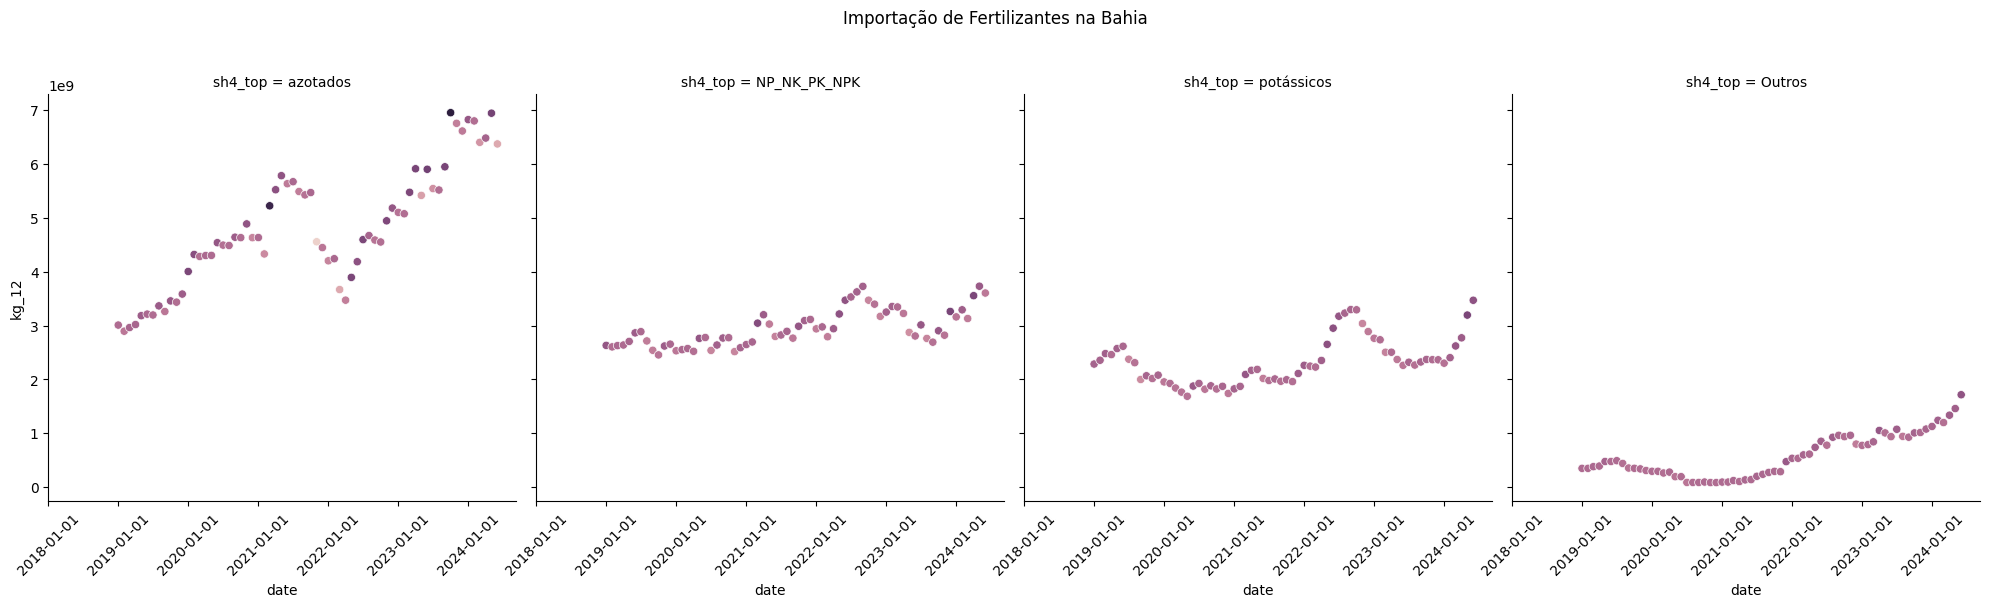

In [15]:
sns.relplot(data=q,x='date',y='kg_12',hue='dif_kg',legend=False,  col='sh4_top').set_xticklabels(rotation=45).fig.suptitle('Importação de Fertilizantes na Bahia',y=1.1)
plt.show()

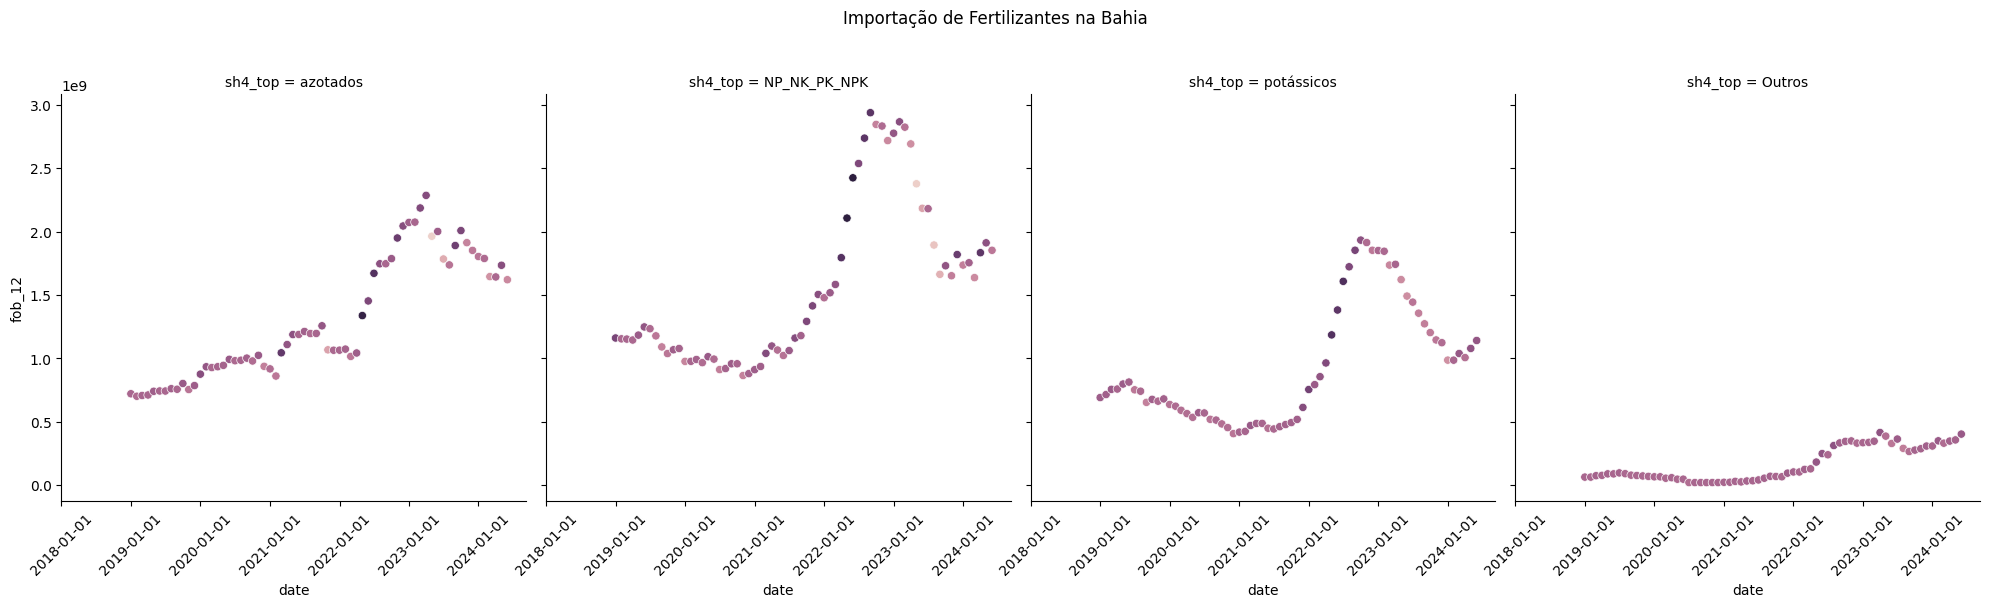

In [16]:
sns.relplot(data=q,x='date',y='fob_12',hue='dif_fob',legend=False,  col='sh4_top').set_xticklabels(rotation=45).fig.suptitle('Importação de Fertilizantes na Bahia',y=1.1)
plt.show()

# Município e SH4

In [17]:
i_mes_mun_sh4=i_1.groupby(by=['date','NO_MUN','NO_SH4_POR'])[['KG_LIQUIDO','VL_FOB']].sum().reset_index()

In [18]:
i_mes_mun_sh4['sh4_top']='Outros'
i_mes_mun_sh4.loc[i_mes_mun_sh4.NO_SH4_POR.isin(top_sh4),'sh4_top']=i_mes_mun_sh4[i_mes_mun_sh4.isin(top_sh4)].NO_SH4_POR

i_mes_mun_sh4['mun_top']='Outros'
i_mes_mun_sh4.loc[i_mes_mun_sh4.NO_MUN.isin(top_mun),'mun_top']=i_mes_mun_sh4[i_mes_mun_sh4.isin(top_mun)].NO_MUN

i_mes_mun_sh4=i_mes_mun_sh4.groupby(by=['date','mun_top','sh4_top'],observed=False)[['KG_LIQUIDO','VL_FOB']].sum().reset_index()

q=pd.DataFrame()
for sh4 in i_mes_mun_sh4.sh4_top.unique():
    for mun in i_mes_mun_sh4.mun_top.unique():
        
        it=i_mes_mun_sh4[(i_mes_mun_sh4.sh4_top==sh4)&(i_mes_mun_sh4.mun_top==mun)].sort_values('date')
        
        it['kg_12']=it.rolling(12).KG_LIQUIDO.sum()
        it['fob_12']=it.rolling(12).VL_FOB.sum()
        it['dif_kg']=it.kg_12-it.shift(1).kg_12
        it['dif_fob']=it.fob_12-it.shift(1).fob_12
        q=pd.concat([q,it]).dropna()

In [19]:
q.sh4_top=q.sh4_top.str.replace('Adubos (fertilizantes) minerais ou químicos, ', '')
q.sh4_top=q.sh4_top.str.replace('contendo dois ou três dos seguintes elementos fertilizantes: azoto (nitrogénio), fósforo e potássio; outros adubos (fertilizantes); produtos do presente capítulo apresentados em tabletes ou formas semelhantes, ', 'NP_NK_PK_NPK')

In [25]:
q=q[q.mun_top.isin(['CONCEICAO DO JACUIPE','CANDEIAS'])]

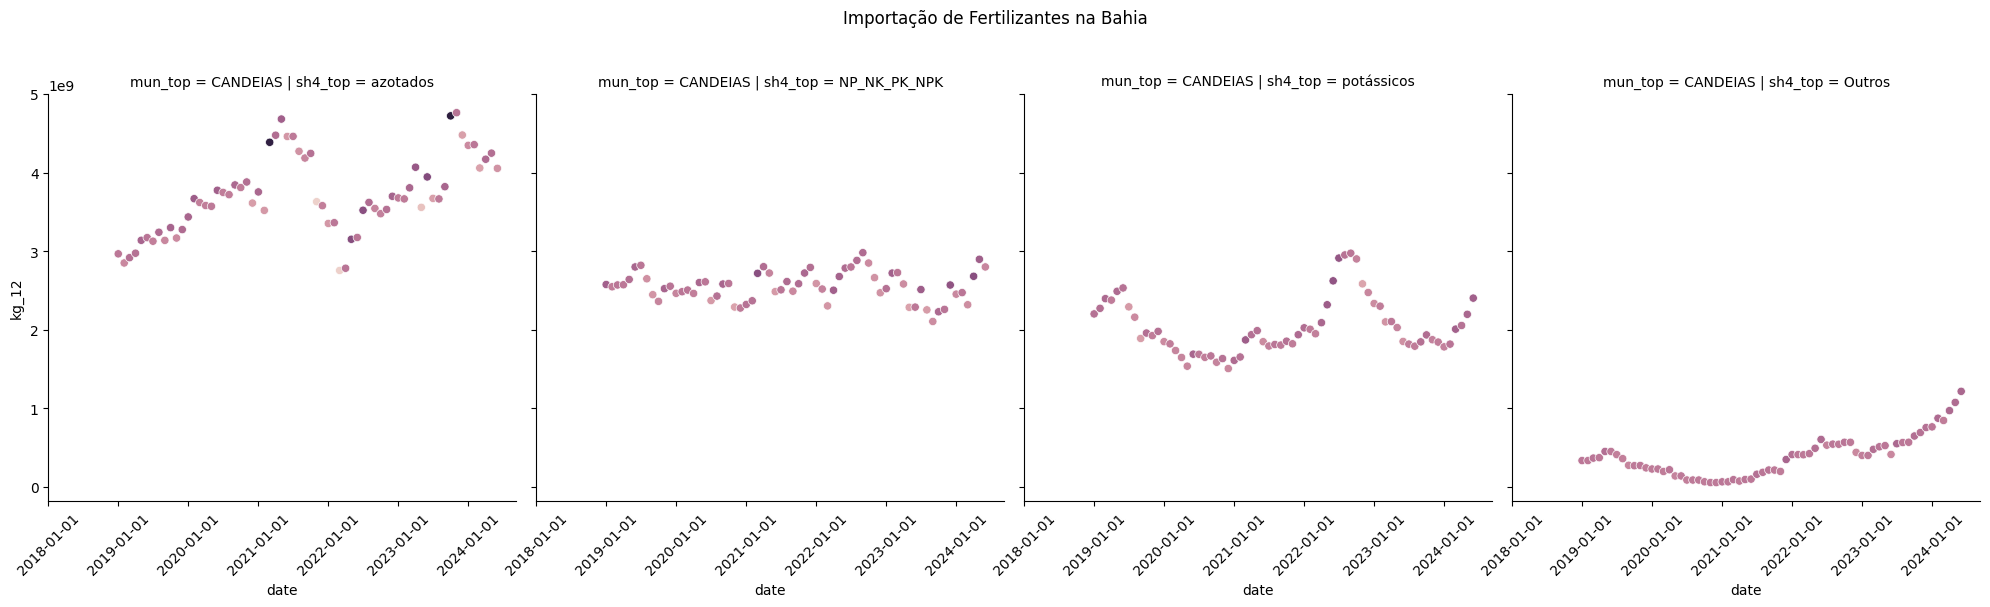

In [36]:
sns.relplot(data=q[q.mun_top=='CANDEIAS'],x='date',y='kg_12',hue='dif_kg',legend=False,  col='sh4_top',row='mun_top').set_xticklabels(rotation=45).fig.suptitle('Importação de Fertilizantes na Bahia',y=1.1)
plt.show()

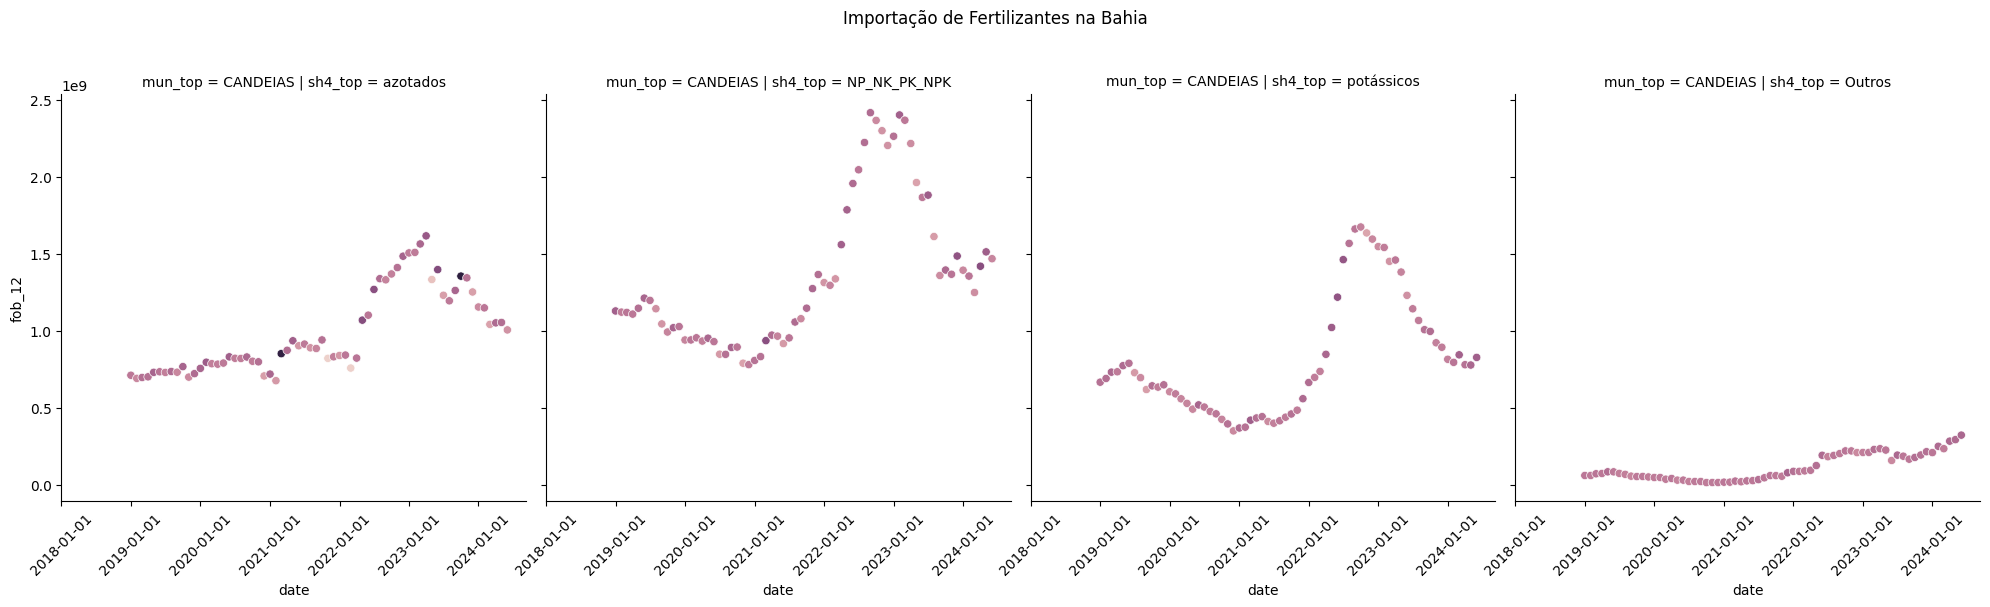

In [37]:
sns.relplot(data=q[q.mun_top=='CANDEIAS'],x='date',y='fob_12',hue='dif_kg',legend=False,  col='sh4_top',row='mun_top').set_xticklabels(rotation=45).fig.suptitle('Importação de Fertilizantes na Bahia',y=1.1)
plt.show()

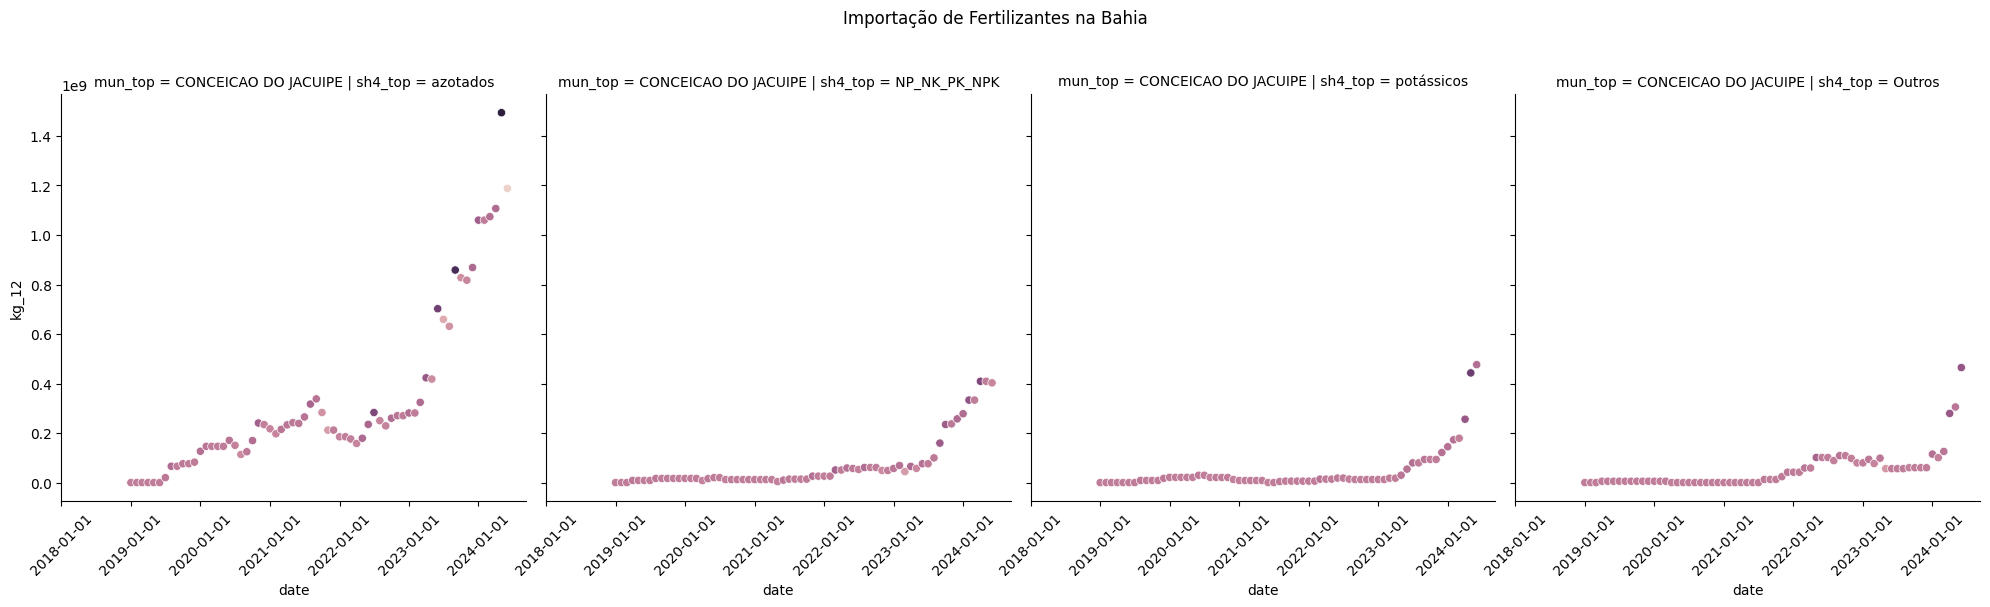

In [34]:
sns.relplot(data=q[q.mun_top=='CONCEICAO DO JACUIPE'],x='date',y='kg_12',hue='dif_fob',legend=False,  col='sh4_top',row='mun_top').set_xticklabels(rotation=45).fig.suptitle('Importação de Fertilizantes na Bahia',y=1.1)
plt.show()

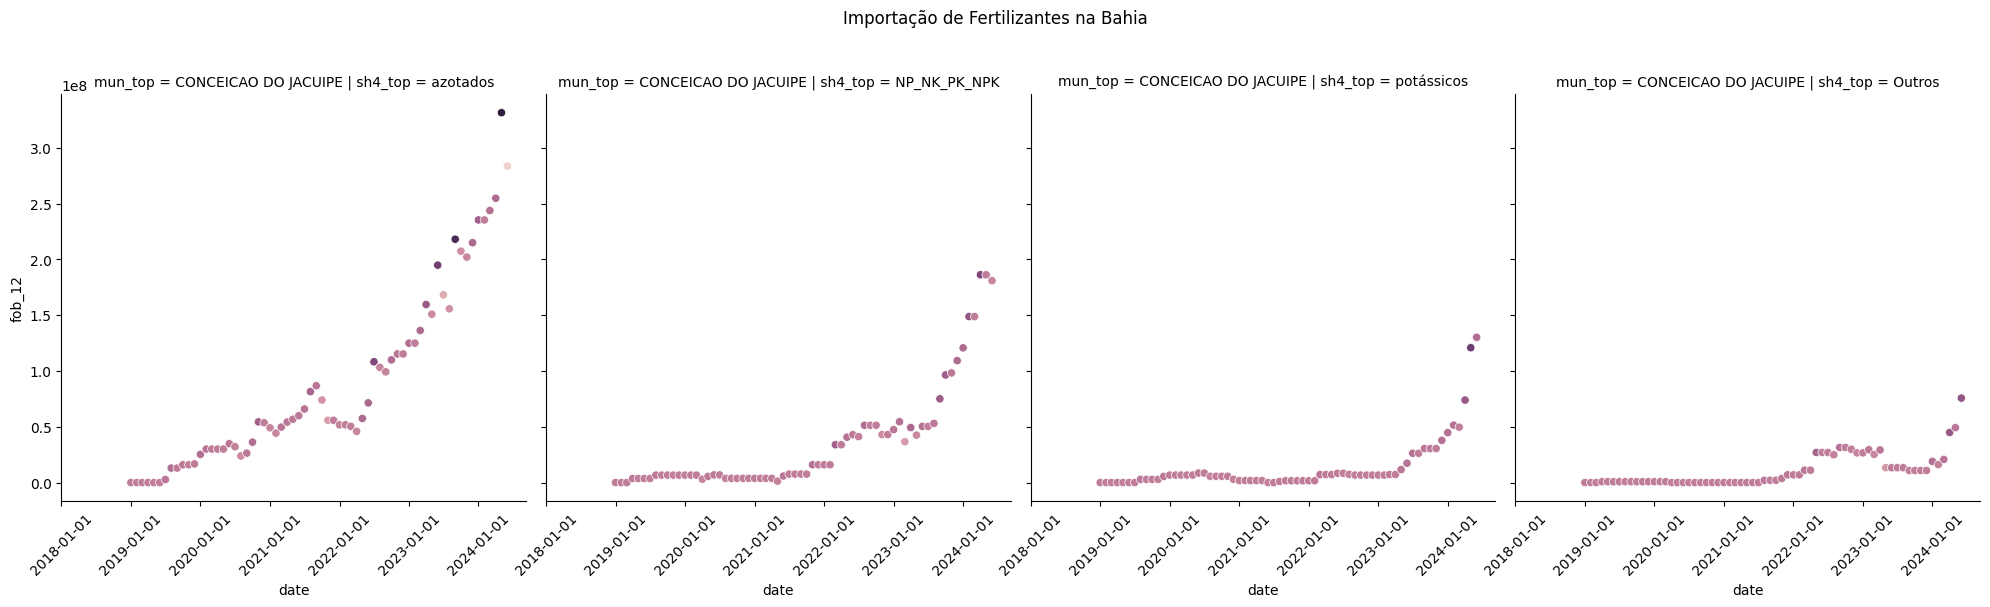

In [35]:
sns.relplot(data=q[q.mun_top=='CONCEICAO DO JACUIPE'],x='date',y='fob_12',hue='dif_fob',legend=False,  col='sh4_top',row='mun_top').set_xticklabels(rotation=45).fig.suptitle('Importação de Fertilizantes na Bahia',y=1.1)
plt.show()

In [22]:
a=

SyntaxError: invalid syntax (62411553.py, line 1)

In [ ]:
pd.set_option('display.max_colwidth', 1000)
nick=pd.DataFrame({'NO_SH4_POR':top,'nick':['nitrogenado','NP_NK_PK_NPK','fosfatados','potássicos']})
display(nick)

In [ ]:
q=q.merge(nick, left_on='sh4_top',right_on='NO_SH4_POR')
q

In [ ]:
sns.relplot(data=q,x='date',y='kg_12',hue='dif_kg',legend=False,  col='nick').set_xticklabels(rotation=45)

In [ ]:
sns.relplot(data=q,x='date',y='fob_12',hue='dif_fob',legend=False,  col='nick').set_xticklabels(rotation=45)

In [ ]:
i_1.columns 

In [ ]:
round(i_1.groupby(by=['CO_ANO','NO_SH4_POR']).KG_LIQUIDO.sum()/10**6)

In [ ]:
i_mes=i_0.groupby(by=['date'])[['KG_LIQUIDO','VL_FOB']].sum().reset_index()
i_mes['kg_12']=i_mes.rolling(12).KG_LIQUIDO.sum()
i_mes['fob_12']=i_mes.rolling(12).VL_FOB.sum()
i_mes['dif_kg']=i_mes.kg_12-i_mes.shift(1).kg_12
i_mes['dif_fob']=i_mes.fob_12-i_mes.shift(1).fob_12
sns.relplot(data=i_mes,x='date',y='kg_12',hue='dif_kg',legend=False).set_xticklabels(rotation=45)

In [ ]:
i_mes['date_num']=i_mes.date.astype(int)
sns.lmplot(data=i_mes,x='date_num',y='kg_12',legend=False,order=2).set_xticklabels(rotation=45)

In [ ]:
i_mes=i_0.groupby(by=['date'])[['KG_LIQUIDO','VL_FOB']].sum().reset_index()
i_mes['kg_12']=i_mes.rolling(12).KG_LIQUIDO.sum()
i_mes['dif']=i_mes.kg_12-i_mes.shift(1).kg_12
sns.relplot(data=i_mes,x='date',y='kg_12',hue='dif',legend=False).set_xticklabels(rotation=45)

In [ ]:
i_0=i_0.dropna()

In [ ]:
i_0['cresc']=i_0.kg_acml-i_0.kg_acml.shift(1)

In [ ]:
g=sns.relplot(data=i_0,x='date',y='kg_acml',hue='cresc',legend=False).fig.suptitle('Importações\n12meses acumulados',y=1.1)
#sns.color_palette(palette='deep', n_colors=2, desat=None, as_cmap=False)
plt.show()

In [ ]:
def predict(i, regressor,l):
    
    pred=pd.DataFrame()
    
    while (i.date.max()-i.date.min()).days/30>=l:

        
        # Limita comprimento em anos
        j=i[i.date>i.date.max()-pd.DateOffset(months=l)]

        
        # Tipifica a data para processamento ML
        j.date=j.date.astype(int)

        # Limita categorias do traino as categorias presentes no teste
        #cat_pred=j[j.date==j.date.max()].CO_MES.values[0]
        #j=j[j.CO_MES==cat_pred]
        
        # Codifica categorias
        #j.CO_MES=j.CO_MES.astype('category')
        #j=pd.get_dummies(j,prefix_sep='~')
    
        # Identifica as variáveis
        train=j[j.date<j.date.max()]
        test=j[j.date==j.date.max()]
        X_train=train[['date']]
        y_train=train['kg_acml']
        X_test=test[['date']]
        y_test=test['kg_acml']

        # Prediz
        regressor.fit(X_train,y_train)
        q=X_test.assign(kg_pred=regressor.predict(X_test)).assign(kg_acm=y_test)
        pred=pd.concat([q,pred])
        i=i[i.date<i.date.max()]
    
    return pred

In [ ]:
i=i_0.copy()

In [ ]:
pred=predict(i,LR,3)

In [ ]:
round(metrics.r2_score(pred['kg_acm'],pred.kg_pred),2)

In [ ]:
i=i_0.copy()

In [ ]:
pred=predict(i,RFR,3)

In [ ]:
round(metrics.r2_score(pred['kg_acm'],pred.kg_pred),2)